### Vamos a cargar los datos

In [1]:
from arreglo_datos import vectorDatos
from transformacion import transformacion_datos
from livelossplot import PlotLosses

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
import torch

from modelo import Net
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import torch.optim as optim
import datetime


Bad key "legend.title_fontsize" on line 22 in
C:\Users\masan\.matplotlib\stylelib\notebook.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
%load_ext autoreload
%autoreload 2

Cargamos los datos de las etiquetas.

In [3]:
path = 'C:\\Users\\masan\\Desktop\\Mario\\ESFM\\Octavo Semestre\\Servicio Social\\Etiquetas'
dic_nombre_marcas = vectorDatos(path)

0
[]


In [4]:
# Vamos a extraer los datos de cada imagen para poder hacer el split de datos.
vectorDeDatos_completos = []
nombreDeImagenes = []
for key in dic_nombre_marcas.keys():
    vectorDeDatos_completos.append(dic_nombre_marcas[key])
    nombreDeImagenes.append(key)

In [5]:
# True: Con esto solo trabajamos las lineas del borde de la carretera.
modo_lineas_borde = True

if modo_lineas_borde:
    vectorDeDatos = []
    for vector in vectorDeDatos_completos:
        vector_temp = [vector[0], vector[1],  vector[-1]]
        vectorDeDatos.append(vector_temp)

#### Vamos a dividir los datos en conjunto de entrenamiento y testeo (60-40).

In [6]:
entrenamiento = int(0.8*len(vectorDeDatos))
datos_entrenamiento = vectorDeDatos[:entrenamiento]
datos_testeo = vectorDeDatos[entrenamiento:]

In [7]:
len(vectorDeDatos)

2238

In [8]:
entrenamiento

1790

#### Vamos a cargar los datos con su respectiva transformación.

In [9]:
# Funcion para quitar puntos
def quitar(puntos):
    temp = torch.empty(3,2, dtype=torch.float64)
    temp = [[puntos[0][0].item(), puntos[0][1].item()],
            [puntos[2][0].item(), puntos[2][1].item()],
            [puntos[1][0].item(), puntos[3][0].item()]
           ]
    return torch.FloatTensor(temp)

In [10]:
# Training
datos_transformados_training = []
for i in range(len(datos_entrenamiento)):
    try:
        sample = transformacion_datos(datos_entrenamiento[i])
        puntos = sample['puntos']
        sample['puntos']  = quitar(puntos)
        datos_transformados_training.append(sample)
    except ValueError:
        pass

# Testeo
datos_transformados_testeo = []
for i in range(len(datos_testeo)):
    try:
        sample = transformacion_datos(datos_testeo[i])
        puntos = sample['puntos']
        sample['puntos']  = quitar(puntos)
        datos_transformados_testeo.append(sample)
    except ValueError:
        pass

Vamos a hacer la funcion para graficar los puntos en las imagenes

In [11]:
def graficar_lineas_target(image, puntos, color, label):
    """
    Esta funcion se encarga de graficar las lineas target
    """
    punto = np.array(puntos)*150.0+60.0
    
    x1, y1 = [punto[0][0], punto[2][0]], [punto[0][1], 20.0]
    x2, y2 = [punto[1][0], punto[2][1]], [punto[1][1], 20.0]
    #x2, y2 = [punto[2][0], punto[3][0]], [punto[2][1], punto[3][1]]
    
    plt.plot(x1, y1, x2, y2, marker='x', color=color, label=label)
    plt.legend()
    plt.imshow(np.asarray(image), cmap='gray')
    
def graficar_lineas_pred(image, puntos, color, label):
    """
    Esta funcion se encarga de graficar las lineas pred
    """
    punto = np.array(puntos)*150.0+60.0
    
    x1, y1 = [punto[0][0], punto[2][0]], [punto[0][1], 20.0]
    x2, y2 = [punto[1][0], punto[2][1]], [punto[1][1], 20.0]
    
    plt.plot(x1, y1, x2, y2, marker='x', color=color, label=label)
    plt.legend()
    plt.imshow(np.asarray(image), cmap='gray')
    

def graficar_todos_puntos(image, puntos, gt_pts=None):
    """
    Esta funcion combina las lineas pred y target
    """
    puntos = puntos.to('cpu')
    gt_pts = gt_pts.to('cpu')

    punto = np.array(puntos)

    # plot ground truth points as green pts
    if gt_pts is not None:
        gt_pts = np.array(gt_pts)

    # Aqui desplegamos las lineas que predice la red
    graficar_lineas_pred(image, punto, color='red', label='Prediction')
    
    # Aqui graficamos las lineas target
    graficar_lineas_target(image, gt_pts, color='blue', label='Target')

    plt.imshow(image, cmap='gray')
    plt.legend()

### Prueba

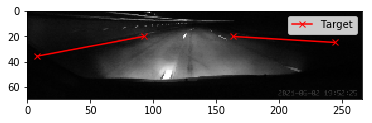

In [16]:
# Imagen aleatoria a imprimir
i = np.random.randint(0, len(datos_transformados_training))

img = datos_transformados_training[i]['image']
puntos = datos_transformados_training[i]['puntos']

graficar_lineas_target(img[0], puntos, color='red', label='Target')

---

#### Cargamos la arquitectura de la red.

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dropout_prob = 0.5
net = Net(dropout_prob)
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1792, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (drop6): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=500, out_features=6, bias=True)
)

### Para ver la cantidad de parametros que tenemos en nuestra red -> 2,745,864

In [18]:
#print(summary(net, (1, 100, 177)))

#### Vamos a ver una muestra de los datos para ver que dimension tienen.

In [19]:
print('Number of images: ', len(datos_transformados_training))

for i in range(4):
    sample = datos_transformados_training[i]
    print(i, sample['image'].size(), sample['puntos'].size())

Number of images:  1790
0 torch.Size([1, 70, 266]) torch.Size([3, 2])
1 torch.Size([1, 70, 266]) torch.Size([3, 2])
2 torch.Size([1, 70, 266]) torch.Size([3, 2])
3 torch.Size([1, 70, 266]) torch.Size([3, 2])


#### Creamos el Train_Loader y el Test_Loader con un Batch de 50 y 5 respectivamente.

In [20]:
# Train Loader
batch_size = 50
train_loader = DataLoader(datos_transformados_training, 
                          batch_size=batch_size,
                          shuffle=True)
# Test Loader
batch_size = 5 
test_loader = DataLoader(datos_transformados_testeo, 
                          batch_size=batch_size,
                          shuffle=True)

---

### En seguida vamos a cargar una muestra con el test loader.

In [21]:
# test the model on a batch of test images
def net_sample_output():
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['puntos']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        images = Variable(images)    
        images = images.to(device)

        # forward pass to get net output
        output_pts = net(images)
        images = images.to(device)
        output_pts = output_pts.to(device)
        
        # reshape to batch_size x 28 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 3, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [22]:
test_images, test_outputs, gt_pts = net_sample_output()

Vamos a graficar la salida, pero antes vamos a cargar las funciones que nos permiten visualizar la salida de nuestros datos y los que predice la CNN.

In [23]:
# visualize the output
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(40,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data  # get the image from it's wrapper
        image = image.cpu()
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts
        
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts
        
        # call show_all_keypoints
        graficar_todos_puntos(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        #plt.axis('off')
    plt.show()

Ahora si vamos a visualizar los puntos.

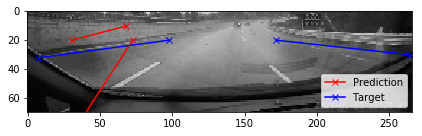

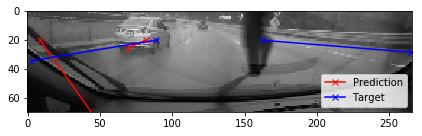

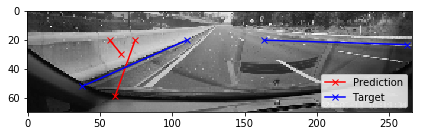

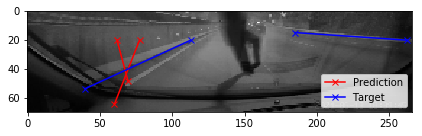

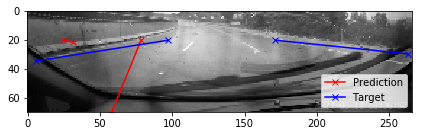

In [24]:
visualize_output(test_images, test_outputs, gt_pts)

In [25]:
gt_pts[0]

tensor([[-0.3520, -0.1852],
        [ 1.3604, -0.2000],
        [ 0.2502,  0.7453]])

In [26]:
test_outputs[0]

tensor([[-0.2124,  0.1916],
        [ 0.0555, -0.3324],
        [ 0.0849, -0.1956]], device='cuda:0', grad_fn=<SelectBackward0>)

---

Ahora ya vamos a entrenar la red.

In [27]:
## TODO: Define the loss and optimization

criterion = nn.MSELoss().to(device)

init_factor = 0.01
learning_rate = 0.001 * init_factor

optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [28]:
loss_plt = []

def train_net(n_epochs):
    # prepare the net for training
    net.train()
    #liveloss = PlotLosses()
    for epoch in range(1, n_epochs + 1):  # loop over the dataset multiple times
        #logs = {}
        scheduler.step()
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['puntos']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = Variable(key_pts.type(torch.FloatTensor))
            images = Variable(images.type(torch.FloatTensor))

            # images, key_pts = Variable(images), Variable(key_pts)    
            images, key_pts = images.to(device), key_pts.to(device)
            
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()
            
            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            
            #logs["Loss"] = running_loss/len(train_loader)
            
        loss_plt.append((running_loss)/len(train_loader)) 
        
        #if epoch == 1 or epoch % 10 == 0:
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,
                    running_loss / len(train_loader)))

    print('Finished Training')

In [29]:
n_epochs = 100

In [30]:
train_net(n_epochs)

C:\Users\masan\miniconda3\envs\cv-nd\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2022-09-19 02:54:56.600953 Epoch 1, Training loss 0.3479514636306299
2022-09-19 02:55:01.234556 Epoch 2, Training loss 0.031782898431022964
2022-09-19 02:55:05.873951 Epoch 3, Training loss 0.02105832935517861
2022-09-19 02:55:10.521045 Epoch 4, Training loss 0.01765657930324475
2022-09-19 02:55:15.172064 Epoch 5, Training loss 0.01559094303391046
2022-09-19 02:55:19.844715 Epoch 6, Training loss 0.015136841710449921
2022-09-19 02:55:24.484314 Epoch 7, Training loss 0.012564200959685776
2022-09-19 02:55:29.127383 Epoch 8, Training loss 0.012801720217491189
2022-09-19 02:55:33.753564 Epoch 9, Training loss 0.011443630468824672
2022-09-19 02:55:38.382494 Epoch 10, Training loss 0.010266922414302826
2022-09-19 02:55:43.010078 Epoch 11, Training loss 0.009684879940727519
2022-09-19 02:55:47.640185 Epoch 12, Training loss 0.009494111148847474
2022-09-19 02:55:52.263486 Epoch 13, Training loss 0.00908052826869405
2022-09-19 02:55:56.901745 Epoch 14, Training loss 0.008857763475841947
2022-09

Vamos a imprimir el Loss para ver como es que nuestro modelo aprendio.

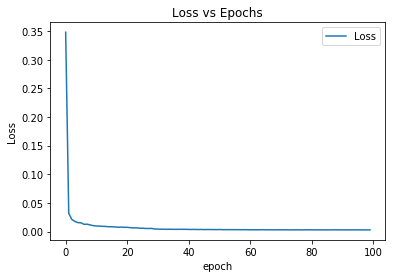

In [31]:
plt.plot(loss_plt,'-')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.title('Loss vs Epochs')
plt.show()

Como podemos observar, el modelo se tiende a aplanar en la epoca 60-80.

Vamos a guardar el aprendizaje de la CNN.

In [32]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'chido.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

---

Ahora visualizaremos los resultados.

Si queremos visualizar los datos de otro entrenamiento aqui abajo cargaremos la ruta del otro modelo.

In [33]:
load_parameters = True
if(load_parameters):
    state_dict = torch.load('saved_models/chido.pt')
    net.load_state_dict(state_dict)

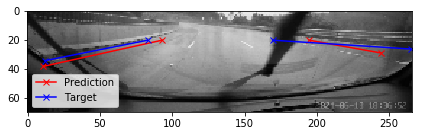

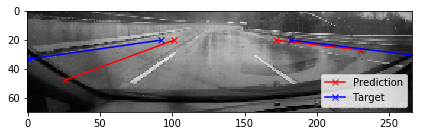

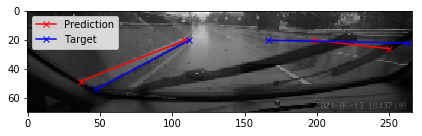

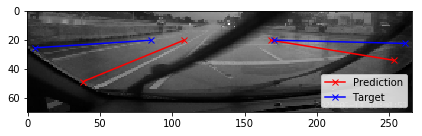

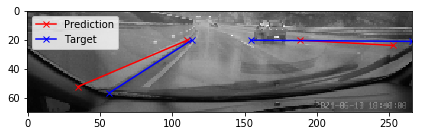

In [50]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

In [31]:
test_outputs[0]

tensor([[-0.1529, -0.0677],
        [ 1.4056, -0.1165],
        [ 0.3862,  0.9013]], device='cuda:0', grad_fn=<SelectBackward0>)

In [32]:
gt_pts[4]

tensor([[-0.0416, -0.0056],
        [ 1.2939, -0.2537],
        [ 0.3684,  0.7970]])

TODO:
 - ~Checar las imagenes que están mal etiquetadas~
 - ~Ecualización del histograma  las imágenes~
 - ~Poner linea Horizontal para solo determinar un parametro en las lineas.~
 - ~Checar Criterion~
 - Dar un shuffle en la particion